In [35]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, concatenate, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

In [2]:
#Import the data
train_data_path = "/kaggle/input/split-atmo-dataset2/train_input.json"
train_labels_path = "/kaggle/input/split-atmo-dataset2/train_labels.json"

val_data_path = "/kaggle/input/split-atmo-dataset2/val_input.json" 
val_labels_path = "/kaggle/input/split-atmo-dataset2/val_labels.json"

train_data = (pd.read_json(train_data_path)).values
train_labels = (pd.read_json(train_labels_path)).values

val_data = (pd.read_json(val_data_path)).values
val_labels = (pd.read_json(val_labels_path)).values

train_atmo_input = np.array([np.array(d[0]) for d in train_data])
train_fft_input = np.array([np.array(d[1]) for d in train_data])
train_labels = np.array(train_labels)
train_altitude = np.array([sublist[0] for sublist in train_labels])
train_distance = np.array([sublist[1] for sublist in train_labels])

val_atmo_input = np.array([np.array(d[0]) for d in val_data])
val_fft_input = np.array([np.array(d[1]) for d in val_data])
val_labels = np.array(val_labels)
val_altitude = np.array([sublist[0] for sublist in val_labels])
val_distance = np.array([sublist[1] for sublist in val_labels])

In [3]:
print(val_distance.shape)
print(train_distance.shape)

(16511,)
(76695,)


**Distance**

In [3]:
#atmostats input model
atmoInput = Input(shape = (51, 1))
x = atmoInput

atmostatsOutput = Flatten()(x)

#fft input model
fftInput = Input(shape = (4096, 1))
y = fftInput

numLayersFFT = 3
for i in range(0, numLayersFFT):
    y = Conv1D(64, kernel_size=4, strides = 1, activation='relu')(y)
    y = MaxPooling1D(pool_size=(8))(y)

fftOutput = Flatten()(y)

#concatenate, feed through another DNN
concatenatedInput = concatenate([atmostatsOutput, fftOutput])
z = concatenatedInput

numLayersFinal = 4
for i in range(0, numLayersFinal):
    z = Dense(64, activation='relu')(z)

#final output layer
output = Dense(1)(z)

#model compilation
model1 = Model(inputs=[atmoInput, fftInput], outputs=output)

opt = Adam(learning_rate=0.001)
model1.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])

model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 4096, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 4093, 64)  │        320 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 511, 64)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 508, 64)   │     16,448 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 63, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 60, 64)    │     16,448 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 51, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 7, 64)     │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 51)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 448)       │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 499)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     32,000 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      4,160 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,761 (303.75 KB)

 Trainable params: 77,761 (303.75 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
numEpochs = 100
size = 128

history1 = model1.fit(
    [train_atmo_input, train_fft_input], train_distance,
    validation_data=([val_atmo_input, val_fft_input], val_distance),
    epochs=numEpochs,
    batch_size=size,
    verbose=1
)

model1.save("src_distance.h5")

Epoch 1/100
  4/600 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - loss: 263545.9062 - mean_absolute_error: 449.7871 

I0000 00:00:1718655852.068477     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


600/600 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - loss: 44890.9180 - mean_absolute_error: 151.6558 - val_loss: 11644.5127 - val_mean_absolute_error: 85.2701
Epoch 2/100
  3/600 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - loss: 14045.0068 - mean_absolute_error: 92.5222

W0000 00:00:1718655884.204105     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - loss: 11592.4326 - mean_absolute_error: 80.5538 - val_loss: 7379.0029 - val_mean_absolute_error: 62.2150
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - loss: 9455.2852 - mean_absolute_error: 69.9983 - val_loss: 6543.7383 - val_mean_absolute_error: 58.7162
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - loss: 8238.0957 - mean_absolute_error: 63.7755 - val_loss: 5471.2852 - val_mean_absolute_error: 50.7565
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - loss: 7344.0239 - mean_absolute_error: 58.9276 - val_loss: 7219.3784 - val_mean_absolute_error: 63.7565
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - loss: 7011.8940 - mean_absolute_error: 57.6359 - val_loss: 6193.2773 - val_mean_absolute_error: 54.3915
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - loss: 6459.6372 - mean_absolute_error: 54.9267 - val_loss: 4630.0513 - val_mean_absolute_error: 44.8094
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 

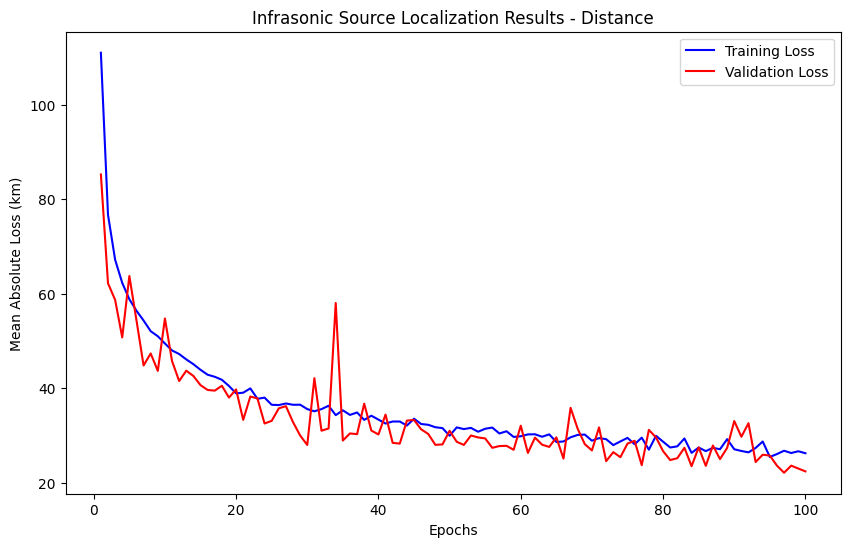

In [5]:
# Extract loss values
train_loss = history1.history['mean_absolute_error']
val_loss = history1.history['val_mean_absolute_error']

# Create a range of epoch numbers
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Loss (km)')
plt.title('Infrasonic Source Localization Results - Distance')
plt.legend()

plt.savefig("Normal_Model_Distances.png")

plt.show()

In [6]:
pd.DataFrame(train_loss).to_csv("distance_train_loss")
pd.DataFrame(val_loss).to_csv("distance_val_loss")

In [3]:
model1 = keras.models.load_model("/kaggle/input/distance_atmo_split/tensorflow2/distance_atmo_split/1/Infrasound Localization.h5")

In [4]:
valDistPredictions = model1.predict([val_atmo_input, val_fft_input]).flatten()

 83/516 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

I0000 00:00:1719286921.586174     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719286921.604567     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


22.375771381192646
14.545161743164073
551.3053515625


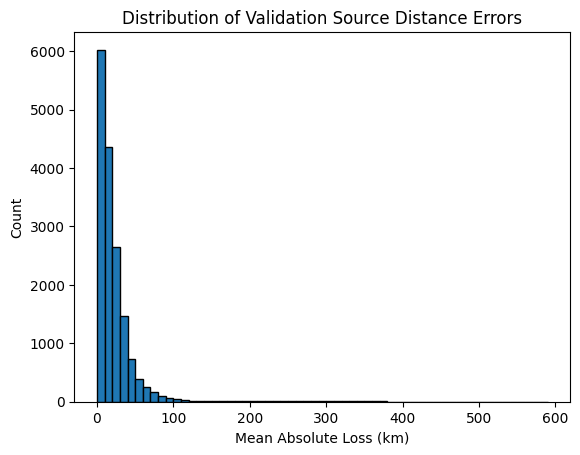

In [6]:
mae_per_sample_dist = np.abs(valDistPredictions - val_distance)
print(np.mean(mae_per_sample_dist))
print(np.median(mae_per_sample_dist))
print(np.max(mae_per_sample_dist))
plt.hist(mae_per_sample_dist, bins=np.arange(0, 600, 10), edgecolor='black')
plt.xlabel("Mean Absolute Loss (km)")
plt.ylabel("Count")
plt.title("Distribution of Validation Source Distance Errors")
plt.savefig("Distance_Error_Distrib.svg")

In [7]:
normalized_mae_per_sample_dist = Normalize(vmin=mae_per_sample_dist.min(), vmax=mae_per_sample_dist.max())

/tmp/ipykernel_35/3931396175.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


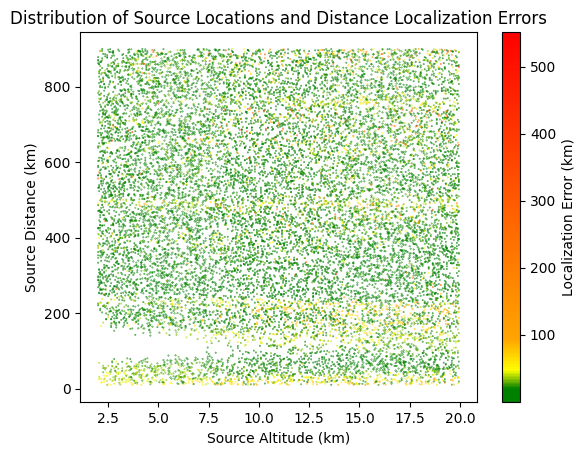

In [19]:
# Define custom colormap
colors = [
    (0.0, "green"),     # 0
    (20/600, "green"),  # 25
    (50/600, "yellow"),  # 100
    (100/600, "orange"),  # 200
    (1.0, "red")       # 600
]

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# Create a scatter plot with the color scale
plt.scatter(val_altitude, val_distance, c=mae_per_sample, cmap=custom_cmap, s=0.10)

# Add color bar
sm = ScalarMappable(cmap=custom_cmap, norm=normalized_mae_per_sample_dist)
sm.set_array([])  # Only needed for older versions of Matplotlib
cbar = plt.colorbar(sm)
cbar.set_label('Localization Error (km)')

# Add labels and title
plt.xlabel("Source Altitude (km)")
plt.ylabel("Source Distance (km)")
plt.title("Distribution of Source Locations and Distance Localization Errors")
plt.savefig("Location_Error_Distributions_Distance_Model_Edited_ColorBar.svg")
plt.show()

**Altitude**

In [15]:
#model compilation
model2 = Model(inputs=[atmoInput, fftInput], outputs=output)

opt = Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])

model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 4096, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 4093, 64)  │        320 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 511, 64)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 508, 64)   │     16,448 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 63, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 60, 64)    │     16,448 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 51, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 7, 64)     │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 51)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 448)       │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 499)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     32,000 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      4,160 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,761 (303.75 KB)

 Trainable params: 77,761 (303.75 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history2 = model2.fit(
    [train_atmo_input, train_fft_input], train_altitude,
    validation_data=([val_atmo_input, val_fft_input], val_altitude),
    epochs=numEpochs,
    batch_size=size,
    verbose=1
)

model2.save("src_altitude.h5")

Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - loss: 13137.2041 - mean_absolute_error: 37.6042 - val_loss: 28.8950 - val_mean_absolute_error: 4.2202
Epoch 2/100
  3/600 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - loss: 27.9090 - mean_absolute_error: 4.3934

W0000 00:00:1718659530.353667     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - loss: 23.6336 - mean_absolute_error: 3.9889 - val_loss: 20.3303 - val_mean_absolute_error: 3.7131
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - loss: 20.0844 - mean_absolute_error: 3.6768 - val_loss: 21.2498 - val_mean_absolute_error: 3.7073
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - loss: 19.2132 - mean_absolute_error: 3.5804 - val_loss: 17.6364 - val_mean_absolute_error: 3.4075
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - loss: 18.3062 - mean_absolute_error: 3.4862 - val_loss: 17.9786 - val_mean_absolute_error: 3.4750
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - loss: 17.7123 - mean_absolute_error: 3.4270 - val_loss: 16.4863 - val_mean_absolute_error: 3.3043
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - loss: 16.9511 - mean_absolute_error: 3.3352 - val_loss: 16.1818 - val_mean_absolute_error: 3.2557
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - loss: 16.6068 - mean_abso

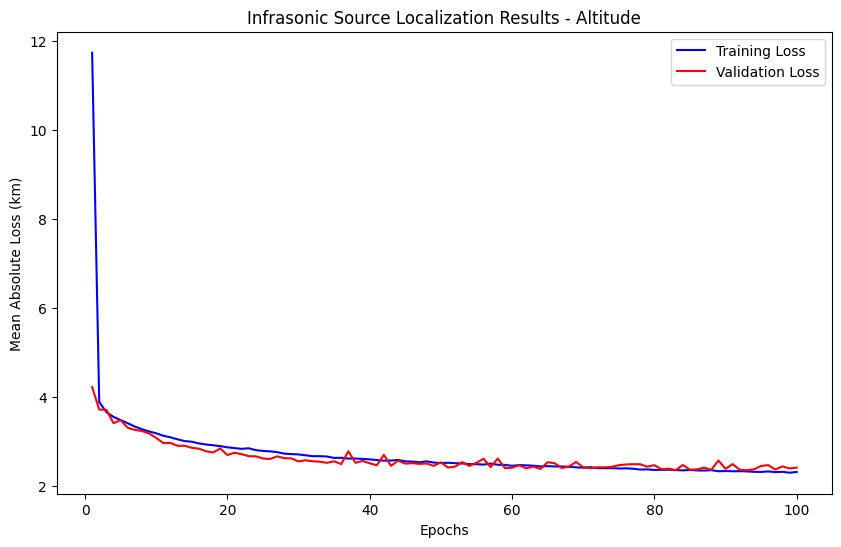

In [19]:
# Extract loss values
train_loss = history2.history['mean_absolute_error']
val_loss = history2.history['val_mean_absolute_error']

# Create a range of epoch numbers
epochs = range(1, len(train_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Loss (km)')
plt.title('Infrasonic Source Localization Results - Altitude')
plt.legend()

plt.savefig("Normal_Model_Altitudes.png")

plt.show()

In [21]:
pd.DataFrame(train_loss).to_csv("altitude_train_loss")
pd.DataFrame(val_loss).to_csv("altitude_val_loss")

In [9]:
model2 = keras.models.load_model('/kaggle/input/altitude_atmo_split/tensorflow2/altitude_atmo_split/1/Altitude data (2).h5')

In [10]:
valAltPredictions = model2.predict([val_atmo_input, val_fft_input]).flatten()

 79/516 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1718918579.215535     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


2.408091982483438
1.9028270721435554
14.215288162231445


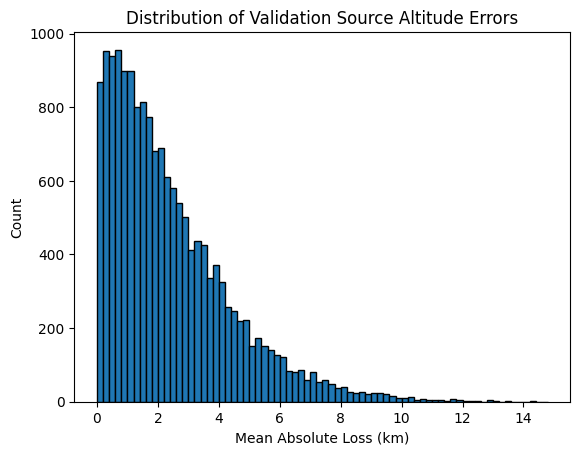

In [11]:
mae_per_sample_alt = np.abs(valAltPredictions - val_altitude)
print(np.mean(mae_per_sample_alt))
print(np.median(mae_per_sample_alt))
print(np.max(mae_per_sample_alt))
plt.hist(mae_per_sample_alt, bins=np.arange(0, 15, 0.2), edgecolor='black')
plt.xlabel("Mean Absolute Loss (km)")
plt.ylabel("Count")
plt.title("Distribution of Validation Source Altitude Errors")
plt.savefig("Altitude_Error_Distrib.svg")

In [12]:
normalized_mae_per_sample_alt = Normalize(vmin=mae_per_sample_alt.min(), vmax=mae_per_sample_alt.max())

/tmp/ipykernel_34/2883375179.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


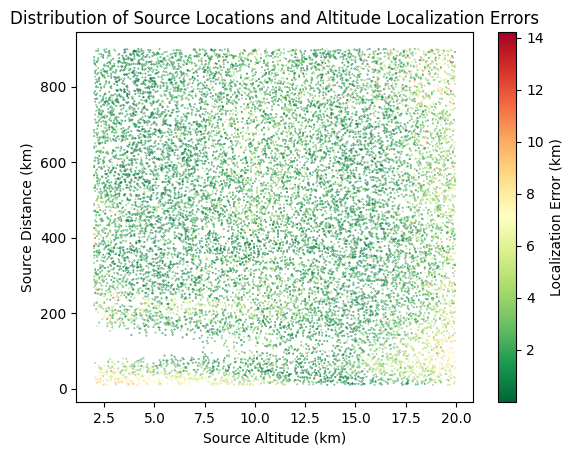

In [16]:
# Choose a colormap
cmap = plt.get_cmap('RdYlGn_r')  # Red for high error, green for low error

# Create a scatter plot with the color scale
plt.scatter(val_altitude, val_distance, c=mae_per_sample, cmap=cmap, s=0.10)

# Add color bar
sm = ScalarMappable(cmap=cmap, norm=normalized_mae_per_sample)
sm.set_array([])  # Only needed for older versions of Matplotlib
cbar = plt.colorbar(sm)
cbar.set_label('Localization Error (km)')

# Add labels and title
plt.xlabel("Source Altitude (km)")
plt.ylabel("Source Distance (km)")
plt.title("Distribution of Source Locations and Altitude Localization Errors")
plt.savefig("Location_Error_Distributions_Altitude_Model.svg")
plt.show()

<Figure size 1000x800 with 0 Axes>

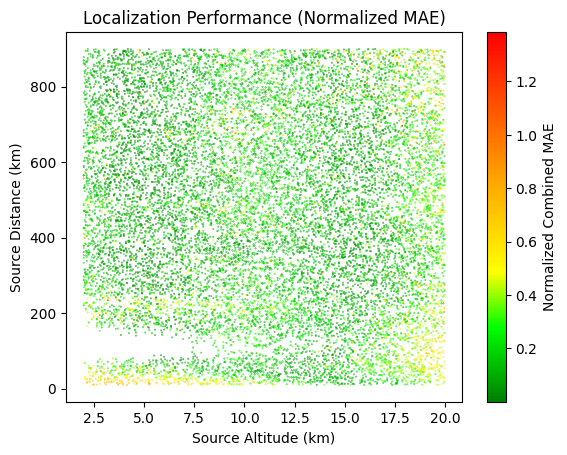

<Figure size 1000x800 with 0 Axes>

In [48]:
# 2-d histogram

mae_dist_normalized = (mae_per_sample_dist - np.min(mae_per_sample_dist)) / (np.max(mae_per_sample_dist) - np.min(mae_per_sample_dist))
mae_alt_normalized = (mae_per_sample_alt - np.min(mae_per_sample_alt)) / (np.max(mae_per_sample_alt) - np.min(mae_per_sample_alt))

combined_normalized_mae = (mae_dist_normalized + mae_alt_normalized)

colors = [
    (0.0, "green"),     
    (0.20, "lime"),  
    (0.35, "yellow"),
    (0.6, "orange"),
    (1.0, "red"),  
]

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# Plot the 2D histogram
plt.scatter(val_altitude, val_distance, c=combined_normalized_mae, cmap=custom_cmap, s=0.10)
plt.colorbar(label='Normalized Combined MAE')

plt.xlabel('Source Altitude (km)')
plt.ylabel('Source Distance (km)')
plt.title('Localization Performance (Normalized MAE)')
plt.savefig("2d_distribution_combined_localization.svg")
plt.figure(figsize=(10, 8))

**Ablations for Distance**

In [22]:
#atmo only model

atmoInput = Input(shape = (51, 1))
x = atmoInput

numLayersFinal = 8
for i in range(0, numLayersFinal):
    x = Dense(64, activation='relu')(x)

#final output layer
output = Dense(1)(x)

#model compilation
model3 = Model(inputs=atmoInput, outputs=output)

opt = Adam(learning_rate=0.001)
model3.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])

model3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 51, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 51, 64)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 51, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 51, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 51, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 51, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 51, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 51, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 51, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 51, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,313 (114.50 KB)

 Trainable params: 29,313 (114.50 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
numEpochs = 100
size = 128

history3 = model3.fit(
    train_atmo_input, train_altitude,
    validation_data=(val_atmo_input, val_altitude),
    epochs=numEpochs,
    batch_size=size,
    verbose=1
)

model3.save("altitude_model_atmo_only.h5")

Epoch 1/100
 42/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 134.1838 - mean_absolute_error: 10.3016

W0000 00:00:1718720350.460109     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 58.0176 - mean_absolute_error: 6.1755 - val_loss: 27.2997 - val_mean_absolute_error: 4.5010
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 27.2174 - mean_absolute_error: 4.4922 - val_loss: 26.9413 - val_mean_absolute_error: 4.4693
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 26.9301 - mean_absolute_error: 4.4784 - val_loss: 26.7328 - val_mean_absolute_error: 4.4653
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 26.9251 - mean_absolute_error: 4.4811 - val_loss: 26.8214 - val_mean_absolute_error: 4.4731
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 26.7101 - mean_absolute_error: 4.4611 - val_loss: 26.8355 - val_mean_absolute_error: 4.4648
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 26.6551 - mean_absolute_error: 4.4621 - val_loss: 26.6789 - val_mean_absolute_error: 4.4620
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 26.7899 - mean_absolute_error: 4.

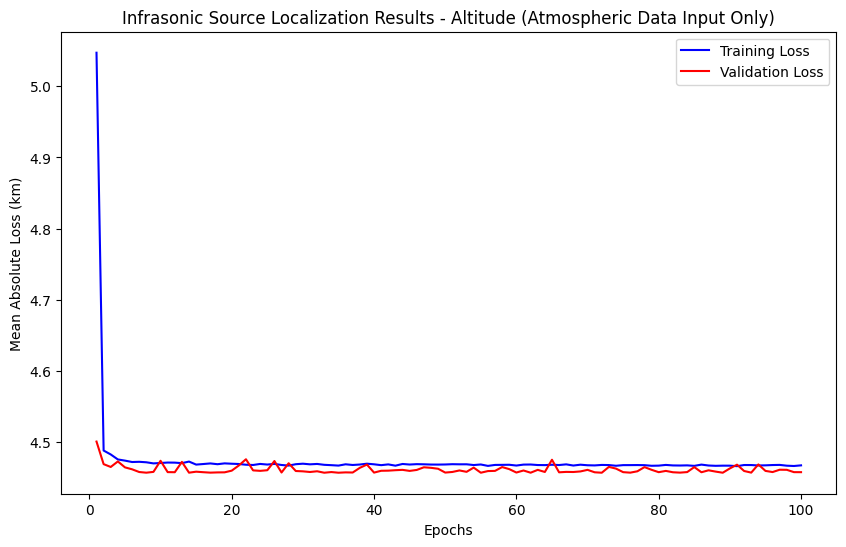

In [26]:
# Extract loss values
train_loss3 = history3.history['mean_absolute_error']
val_loss3 = history3.history['val_mean_absolute_error']

# Create a range of epoch numbers
epochs = range(1, len(train_loss3) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss3, 'b-', label='Training Loss')
plt.plot(epochs, val_loss3, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Loss (km)')
plt.title('Infrasonic Source Localization Results - Altitude (Atmospheric Data Input Only)')
plt.legend()

plt.savefig("Ablated_Model_Altitude_Atmo_Only.svg")

plt.show()

In [27]:
#fft input model
fftInput = Input(shape = (4096, 1))
y = fftInput

numLayersFFT = 3
for i in range(0, numLayersFFT):
    y = Conv1D(64, kernel_size=4, padding='same', strides = 1, activation='relu')(y)
    y = MaxPooling1D(pool_size=(8))(y)

fftOutput = Flatten()(y)

numLayersFinal = 4
for i in range(0, numLayersFinal):
    y = Dense(64, activation='relu')(y)

#final output layer
output = Dense(1)(y)

#model compilation
model4 = Model(inputs=fftInput, outputs=output)

opt = Adam(learning_rate=0.001)
model4.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])

model4.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 4096, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 4096, 64)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 512, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 512, 64)        │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 8, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,921 (195.00 KB)

 Trainable params: 49,921 (195.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
numEpochs = 5
size = 128

history3 = model3.fit(
    train_fft_input, train_distance,
    validation_data=(val_fft_input, val_distance),
    epochs=numEpochs,
    batch_size=size,
    verbose=1
)

model3.save("distance_model_fft_only.h5")

Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - loss: 111537.0078 - mean_absolute_error: 273.0868 - val_loss: 63887.7305 - val_mean_absolute_error: 216.4966
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - loss: 63900.3359 - mean_absolute_error: 217.3840 - val_loss: 63976.9688 - val_mean_absolute_error: 216.5783
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - loss: 63793.6953 - mean_absolute_error: 217.5688 - val_loss: 63912.2070 - val_mean_absolute_error: 216.5184
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - loss: 63861.9609 - mean_absolute_error: 217.4567 - val_loss: 63847.1602 - val_mean_absolute_error: 216.4982
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - loss: 63715.6172 - mean_absolute_error: 217.3623 - val_loss: 63851.1367 - val_mean_absolute_error: 216.5082
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - loss: 63606.8516 - mean_absolute_error: 216.8470 - val_loss: 63855.9375 - val_mean_absolute_error: 216.4733
Epoch 7/1